# Data z reálné jízdy (RSX-UM7)
### Zkoumání pro korelaci s realitou

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import tconsumption
from umparse import um_csv_parser, make_geojson
import matplotlib.pyplot as plt
from scipy.signal import hilbert, argrelextrema
import ruptures as rpt
import importlib
import os
from csv2geojson import prep

In [2]:
df = um_csv_parser("../testing-data/um7/um7capture_2023-09-29_06-26-06.csv")

Index(['time', 'packet_type', 'gps_latitude', 'gps_longitude', 'gps_altitude',
       'gps_course', 'gps_speed', 'gps_time', 'gyro_proc_x', 'gyro_proc_y',
       'gyro_proc_z', 'gyro_proc_time', 'accel_proc_x', 'accel_proc_y',
       'accel_proc_z', 'accel_proc_time', 'mag_proc_x', 'mag_proc_y',
       'mag_proc_z', 'mag_proc_time', 'velocity_north', 'velocity_east',
       'velocity_up', 'velocity_time'],
      dtype='object')


In [3]:
geojson = make_geojson(df["gps_latitude"], df["gps_longitude"])
with open("/tmp/output.geojson", "w") as f:
    f.write(geojson)

<Axes: xlabel='cumulative_distance_m'>

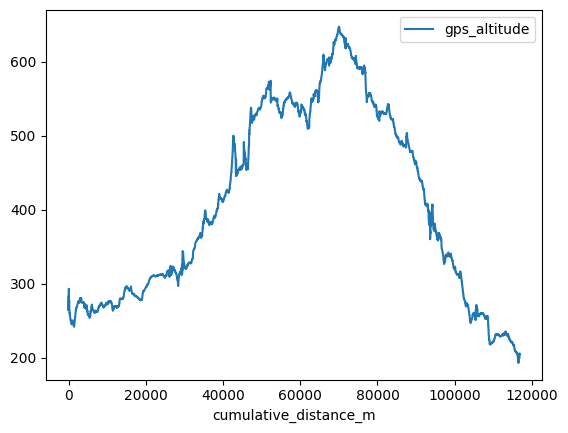

In [4]:
df.plot(x="cumulative_distance_m", y=["gps_altitude"])

### Opava západ --> Krnov-Cvilín
> Vybrání části k sledování a předzpracování

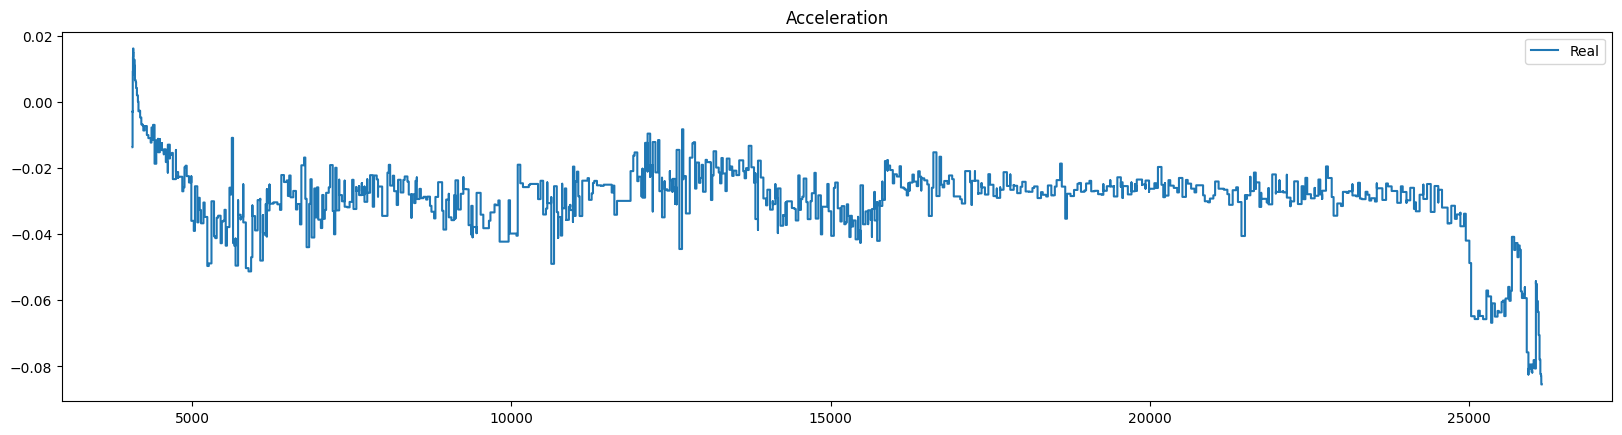

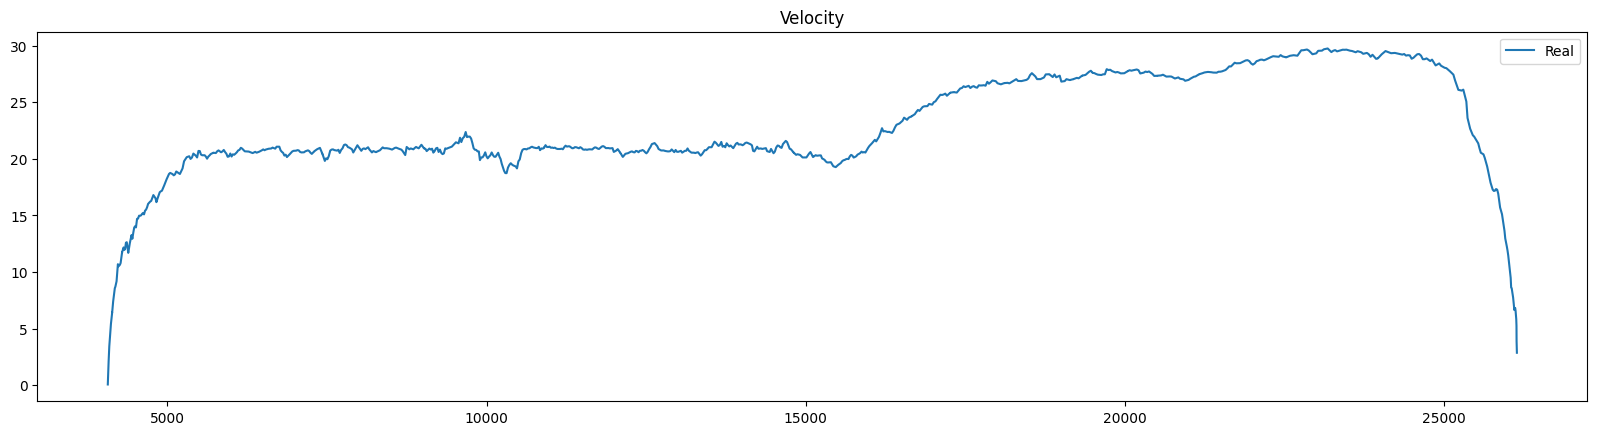

In [5]:
df["accel_proc_y"] *= -1 # Korekce pro jízdní směr

df_slice = df.loc[1080:3510]

plt.figure().set_figwidth(20)
plt.plot(df_slice["cumulative_distance_m"], df_slice["accel_proc_y"])
plt.title("Acceleration")
plt.legend(["Real"], loc ="upper right")
plt.show()

plt.figure().set_figwidth(20)
plt.plot(df_slice["cumulative_distance_m"], df_slice["gps_speed"])
plt.title("Velocity")
plt.legend(["Real"], loc ="upper right")
plt.show()

### Vytvoření geojsonu

In [6]:
prep({
    # "input": "NOT NEEDED",
    "output": "../testing-data/um7/um7capture_2023-09-29_06-26-06_opava-krnov.geojson",
    "host": "localhost",
    "dbname": "railway_mapdb",
    "dbuser": "postgres",
    "dbpass": "mysecretpassword",
    "dbtable": "train_testing_data"
}, df=df_slice)

ERROR 1: libcfitsio.so.10: cannot open shared object file: No such file or directory
ERROR 1: libcfitsio.so.10: cannot open shared object file: No such file or directory
ERROR 1: libhdf5.so.310: cannot open shared object file: No such file or directory
ERROR 1: libhdf5.so.310: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libnetcdf.so.19: cannot open shared object file: No such file or directory
ERROR 1: libnetcdf.so.19: cannot open shared object file: No such file or directory
ERROR 1: libarrow.so.1300: cannot open shared object file: No such file or directory
ERROR 1: libarrow.so.1300: cannot open shared object file: No such file or directory
ERROR 1: libmariadb.so.3: cannot open shared object file: No such file or directory
ERROR 1: libmariadb.so.3: cannot open shared object file: No such fi

In [94]:
def compare_data(df_measured, geojson_path: str):
    # Data identification
    data_name = os.path.basename(geojson_path).split(".")[0]

    # Calculated data
    c = tconsumption.Consumption()
    c.params["mass_locomotive"] = 56000
    c.params["mass_wagon"] = 31490 + 33000
    c.variable_params = {
        "Elevation smoothing": 100,
        "Curve smoothing": 10,
        "Curve A": 999,
        "Curve B": 100,
        "Running a": 2,
        "Running b": 0.054,
        "Running c": 0.00034,
        "Recuperation coefficient": 0.70,
        "Comfortable acceleration": 0.98
    }
    c.load_from_file(geojson_path)

    # Modifying some parameters
        # Source: https://cs.wikipedia.org/wiki/Motorov%C3%BD_v%C5%AFz_860
    c.params["power_limit"] = 480*1000

    # Running the simulation
    c.run()

    # Plotting

    plt.figure().set_figwidth(20)
    plt.plot(c.series["dist_values"], [x[2] for x in c.points])
    plt.title("Elevation")
    plt.show()

    plt.figure().set_figwidth(20)
    plt.plot(c.series["dist_values"], c.series["velocity_values"])
    plt.plot(c.series["dist_values"], df_measured["gps_speed"])
    plt.plot(c.series["dist_values"], c.max_velocities_in_mps)
    plt.title("Velocity")
    plt.legend(["Simulation", "Real", "Limit"], loc ="upper right")
    plt.show()

    plt.figure().set_figwidth(20)
    # plt.plot(c.series["dist_values"], c.series["acceleration_values"])
    plt.plot(c.series["dist_values"], df_measured["accel_proc_y"])
    plt.title("Acceleration")
    plt.legend(["Real"], loc ="upper right")
    plt.show()

    plt.figure().set_figwidth(20)
    plt.plot(c.series["dist_values"], c.series["acceleration_values"])
    # plt.plot(c.series["dist_values"], df_measured["accel_proc_y"])
    plt.title("Acceleration")
    plt.legend(["Simulation"], loc ="upper right")
    plt.show()

    plt.figure().set_figwidth(20)
    plt.plot(c.series["dist_values"][:100], c.series["acceleration_values"][:100])
    # plt.plot(c.series["dist_values"], df_measured["accel_proc_y"])
    plt.title("Acceleration")
    plt.legend(["Simulation"], loc ="upper right")
    plt.show()

    # plt.figure().set_figwidth(20)
    # plt.scatter(c.series["dist_values"], c.series["velocity_values"])
    # plt.title("Calculated velocity")
    # plt.show()

    # plt.figure().set_figwidth(20)
    # plt.scatter(c.series["dist_values"], list(df_measured["tm_rychlost_3_napravy"]))
    # plt.title("Real velocity")
    # plt.show()

    # plt.figure().set_figwidth(20)
    # plt.plot(c.series["dist_values"], c.max_velocities_in_mps)
    # plt.title("Velocity limit")
    # plt.show()

    # return c.series

0.0024414200920831676 0.98
1.0 0.98
1.0 0.98
1.0 0.98
1.0 0.98
1.0 0.98
1.0 0.98
0.0005652326351414014 0.98
0.0009182300018827015 0.98
1.0 0.98
1.0 -0.98
1.0 -0.98
0.0012893182684783244 0.98
1.0 -0.98
1.0 0.98
0.0004591064665566785 0.98
1.0 0.973533010420417
1.0 0.9734764284121847
1.0 0.9734198595561938
0.00022731347008233863 0.9733633038470951
1.0 0.7918119484068719
1.0 0.7917871866574862
0.001385145456329245 0.7917624280052696
1.0 -0.98
1.0 -0.98
1.0 -0.98
0.001132876364083816 0.7289642419589006
0.0009912578595002914 0.6732449502934398
1.0 -0.98
1.0 -0.98
1.0 -0.98
0.00044630094184920324 0.6265740093864
1.0 -0.98
1.0 -0.98
0.0013469107441000645 0.5543977595260889
1.0 -0.98
1.0 -0.98
1.0 -0.98
0.0006919830367602927 0.5260198648179534
1.0 -0.98
1.0 -0.98
0.0024173408634352543 0.4779009768567375
1.0 -0.98
1.0 -0.98
1.0 -0.98
0.0012090320189959319 0.4589935630914358
1.0 -0.98
1.0 -0.98
1.0 -0.98
1.0 -0.98
0.002022416976430194 0.4264528191983165
1.0 -0.98
1.0 -0.98
0.002726141166273531 0.

/home/sawy/Dev/enet-sz-consumption-api/train-exploration/tconsumption.py:357: RuntimeWarning: invalid value encountered in scalar divide
  # NOTE: No acceleration capping - REMOVED (power capping)


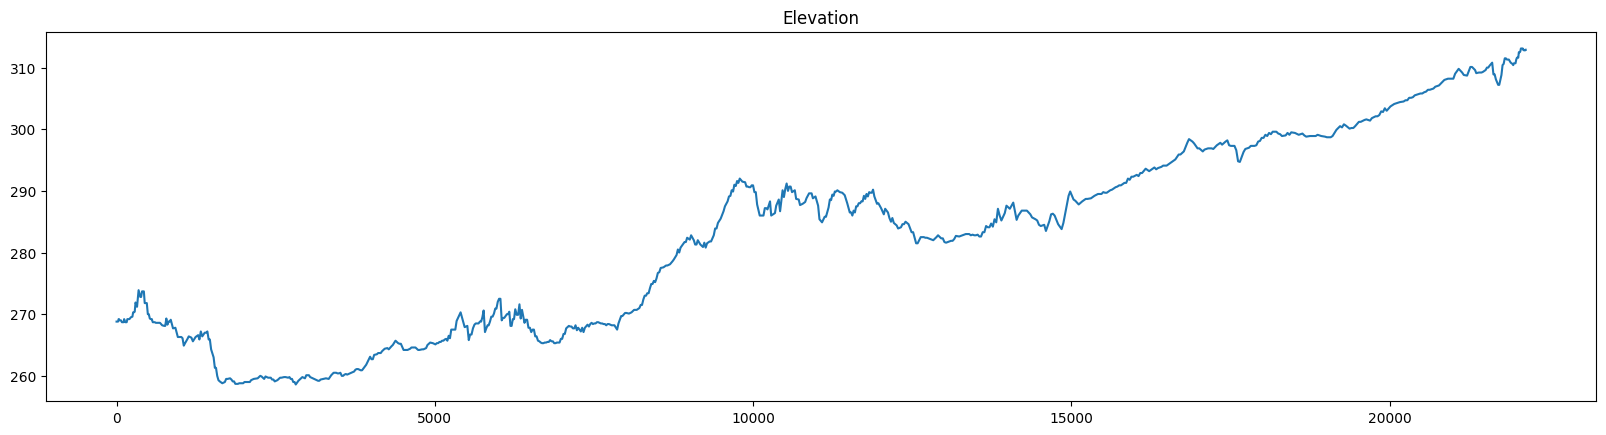

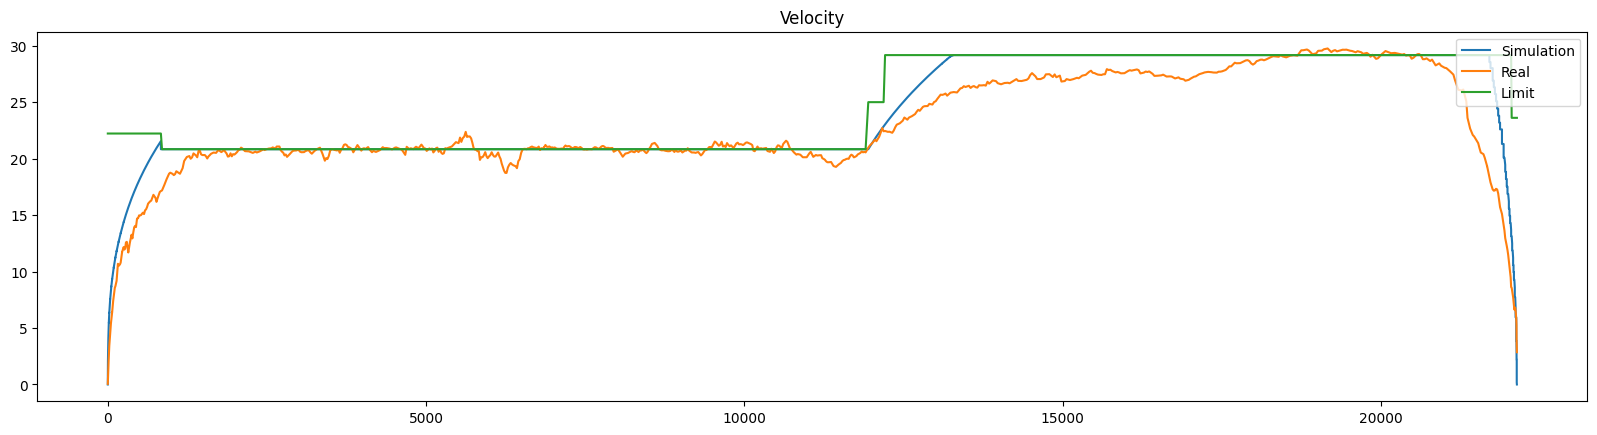

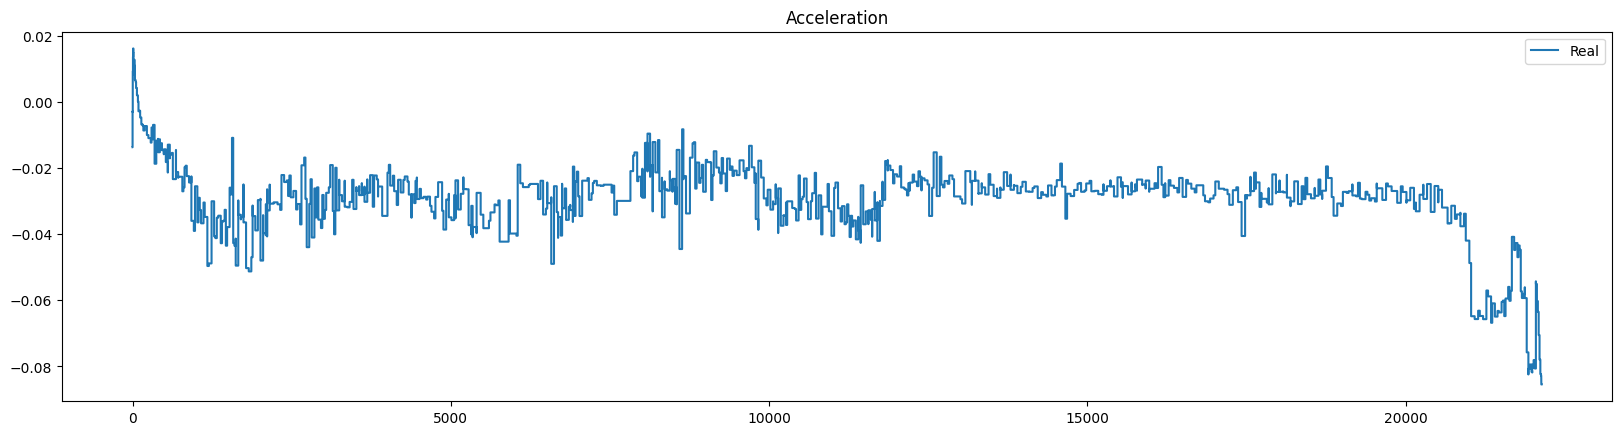

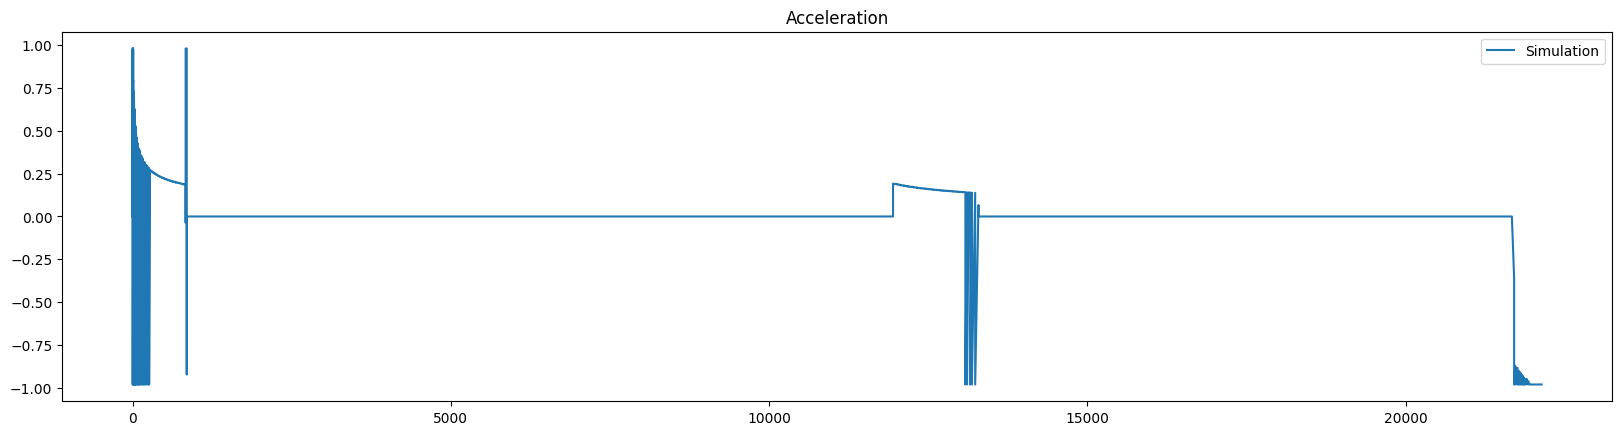

In [102]:
importlib.reload(tconsumption)

compare_data(
    df_slice,
    "../testing-data/um7/um7capture_2023-09-29_06-26-06_opava-krnov.geojson"
)